In [30]:
import os
import numpy as np
import pandas as pd
from PIL import Image, UnidentifiedImageError  
from tensorflow.keras.utils import to_categorical

In [31]:
# Paths
csv_file = 'C:/Users/yatin/Downloads/yelp_photos/yelp.csv'  
images_folder = 'C:/Users/yatin/Downloads/yelp_photos/photos'  

In [32]:
# Load CSV
data = pd.read_csv(csv_file, nrows=1000)

# Prepare labels and photo paths
labels = data['label'].astype('category').cat.codes 
label_mapping = dict(enumerate(data['label'].astype('category').cat.categories))  # Map numeric labels back to strings
photo_paths = [os.path.join(images_folder, f"{photo_id}.jpg") for photo_id in data['photo_id']]

# Load images and resize them to a consistent shape (e.g., 64x64)
image_size = (64, 64)
images = []
valid_labels = []  

for i, path in enumerate(photo_paths):
    if os.path.exists(path):  # Check if file exists
        try:
            with Image.open(path) as img:
                img = img.resize(image_size)
                images.append(np.array(img) / 255.0) 
                valid_labels.append(labels[i])  
        except (UnidentifiedImageError, IOError):  
            print(f"Skipping file: {path} (unreadable)")
    else:
        print(f"File not found: {path}")

images = np.array(images)  
valid_labels = to_categorical(valid_labels, num_classes=len(label_mapping))  

print(f"Loaded {len(images)} images.")

Loaded 1000 images.


In [33]:
# Define the discriminator model
def build_discriminator(input_shape, label_dim):
    image_input = layers.Input(shape=input_shape, name="image_input")
    label_input = layers.Input(shape=(label_dim,), name="label_input")
    
    x = layers.Flatten()(image_input)
    y = layers.Flatten()(label_input)
    concatenated = layers.Concatenate()([x, y])
    
    x = layers.Dense(128, activation="relu")(concatenated)
    x = layers.Dense(1, activation="sigmoid")(x)
    
    return Model([image_input, label_input], x, name="discriminator")


In [34]:
def build_generator(latent_dim, label_dim, image_shape):
    noise_input = layers.Input(shape=(latent_dim,), name="noise_input")
    label_input = layers.Input(shape=(label_dim,), name="label_input")
    
    # Concatenate noise and label inputs
    x = layers.Concatenate()([noise_input, label_input])
    x = layers.Dense(128, activation="relu")(x)
    
    # Calculate the total number of pixels in the image
    total_pixels = np.prod(image_shape)  # Convert shape to a Python integer
    
    x = layers.Dense(total_pixels, activation="sigmoid")(x)
    x = layers.Reshape(image_shape)(x)
    
    return Model([noise_input, label_input], x, name="generator")



In [35]:
import tensorflow as tf
from tensorflow.keras import layers, Model

# Initialize models
image_shape = (64, 64, 3)
label_dim = 5
latent_dim = 100

discriminator = build_discriminator(image_shape, label_dim)
generator = build_generator(latent_dim, label_dim, image_shape)

# Compile discriminator
discriminator.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# Freeze discriminator weights when training the generator
discriminator.trainable = False

# Combined model for training generator
noise_input = layers.Input(shape=(latent_dim,))
label_input = layers.Input(shape=(label_dim,))
fake_image = generator([noise_input, label_input])
validity = discriminator([fake_image, label_input])

combined = Model([noise_input, label_input], validity)
combined.compile(optimizer="adam", loss="binary_crossentropy")

# Ensure models are initialized before training
discriminator.summary()
generator.summary()
combined.summary()

Model: "discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ image_input (InputLayer)      │ (None, 64, 64, 3)         │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ label_input (InputLayer)      │ (None, 5)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ flatten_10 (Flatten)          │ (None, 12288)             │               0 │ image_input[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ flatten_11 (Flatten)          │ (None, 5)                 │               0 │ label_input[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate_10 (Concatenate)  │ (None, 12293)             │               0 │ flatten_10[0][0],          │
│                               │                           │                 │ flatten_11[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_20 (Dense)              │ (None, 128)               │       1,573,632 │ concatenate_10[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_21 (Dense)              │ (None, 1)                 │             129 │ dense_20[0][0]             │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 1,573,761 (6.00 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 1,573,761 (6.00 MB)

Model: "generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ noise_input (InputLayer)      │ (None, 100)               │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ label_input (InputLayer)      │ (None, 5)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate_11 (Concatenate)  │ (None, 105)               │               0 │ noise_input[0][0],         │
│                               │                           │                 │ label_input[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_22 (Dense)              │ (None, 128)               │          13,568 │ concatenate_11[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_23 (Dense)              │ (None, 12288)             │       1,585,152 │ dense_22[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ reshape_5 (Reshape)           │ (None, 64, 64, 3)         │               0 │ dense_23[0][0]             │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 1,598,720 (6.10 MB)

 Trainable params: 1,598,720 (6.10 MB)

 Non-trainable params: 0 (0.00 B)

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)   │ (None, 100)               │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ input_layer_11 (InputLayer)   │ (None, 5)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ generator (Functional)        │ (None, 64, 64, 3)         │       1,598,720 │ input_layer_10[0][0],      │
│                               │                           │                 │ input_layer_11[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ discriminator (Functional)    │ (None, 1)                 │       1,573,761 │ generator[0][0],           │
│                               │                           │                 │ input_layer_11[0][0]       │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 3,172,481 (12.10 MB)

 Trainable params: 1,598,720 (6.10 MB)

 Non-trainable params: 1,573,761 (6.00 MB)

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from scipy.linalg import sqrtm

# Define training parameters
epochs = 40
batch_size = 128
latent_dim = 100

# Initialize metrics
g_losses, d_losses, d_accuracies = [], [], []

for epoch in range(epochs):
    # Generate random noise and labels for fake images
    noise = tf.random.normal((batch_size, latent_dim))
    fake_labels = tf.keras.utils.to_categorical(
        tf.random.uniform((batch_size,), 0, label_dim, dtype=tf.int32), num_classes=label_dim
    )
    fake_imgs = generator.predict([noise, fake_labels])
    
    # Prepare real images and labels (replace this with actual data)
    real_imgs = tf.random.normal((batch_size, *image_shape))
    real_labels = tf.keras.utils.to_categorical(
        tf.random.uniform((batch_size,), 0, label_dim, dtype=tf.int32), num_classes=label_dim
    )
    
    # Train discriminator
    d_loss_real = discriminator.train_on_batch([real_imgs, real_labels], tf.ones((batch_size, 1)))
    d_loss_fake = discriminator.train_on_batch([fake_imgs, fake_labels], tf.zeros((batch_size, 1)))
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
    
    # Train generator
    g_loss = combined.train_on_batch([noise, fake_labels], tf.ones((batch_size, 1)))
    
    # Ensure scalar values for printing
    d_loss_value = float(d_loss[0])  # Extract scalar loss
    d_accuracy = float(d_loss[1])  # Extract scalar accuracy
    g_loss_value = float(g_loss) if not isinstance(g_loss, (list, tuple)) else float(g_loss[0])  # Ensure scalar

    # Print progress
    print(f"Epoch {epoch + 1}/{epochs} | D Loss: {d_loss_value:.4f}, D Accuracy: {d_accuracy * 100:.2f}%, G Loss: {g_loss_value:.4f}")


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


AttributeError: 'NoneType' object has no attribute 'update_state'

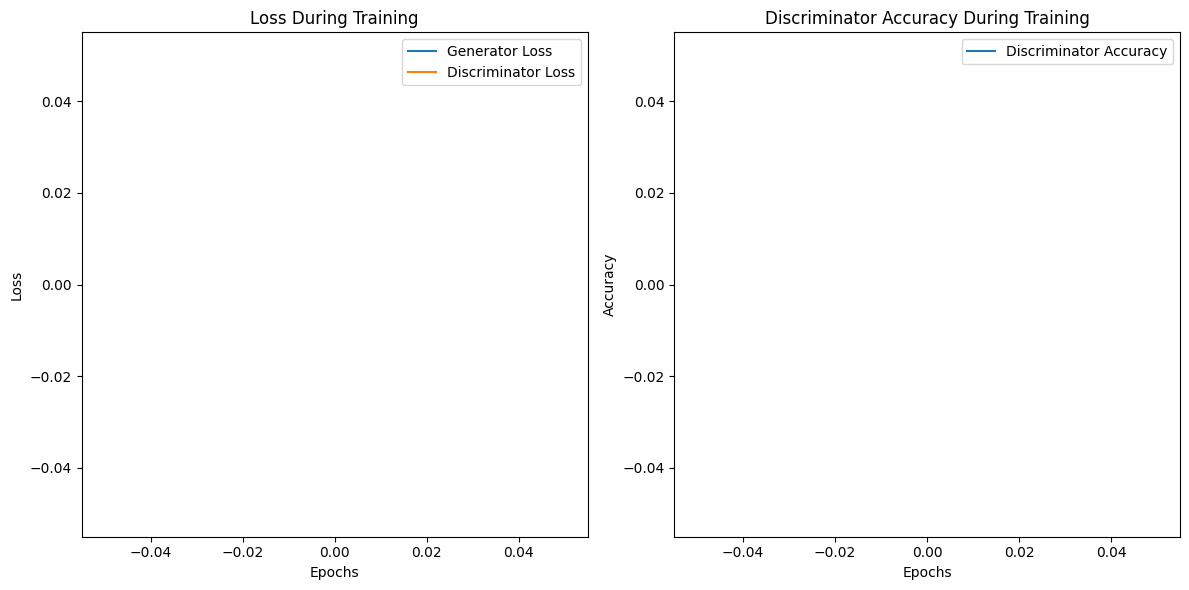

In [47]:
# Plot losses and accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(g_losses, label="Generator Loss")
plt.plot(d_losses, label="Discriminator Loss")
plt.title("Loss During Training")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(d_accuracies, label="Discriminator Accuracy")
plt.title("Discriminator Accuracy During Training")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


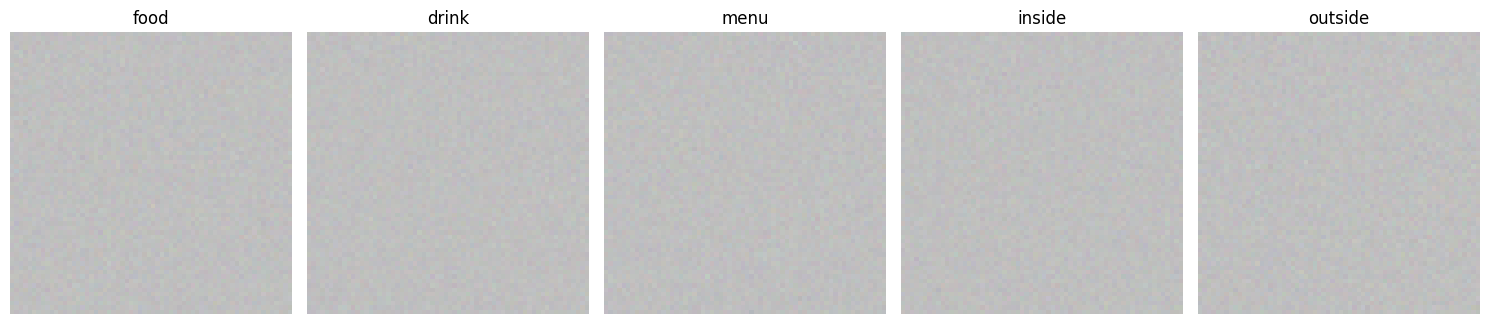

In [48]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
latent_dim = 100  
num_images = 5  
label_dim = len(label_mapping)  

# Generate random noise
noise = np.random.normal(0, 1, (num_images, latent_dim))
selected_labels = ['food', 'drink', 'menu', 'inside', 'outside']
labels = np.array([list(label_mapping.keys())[list(label_mapping.values()).index(lbl)] for lbl in selected_labels])

# One-hot encode labels
one_hot_labels = tf.keras.utils.to_categorical(labels, num_classes=label_dim)

# Generate images
generated_images = generator.predict([noise, one_hot_labels])

generated_images = (generated_images * 127.5 + 127.5).astype(np.uint8)

# Display generated images
plt.figure(figsize=(15, 5))
for i, img in enumerate(generated_images):
    plt.subplot(1, num_images, i+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(selected_labels[i])
plt.tight_layout()
plt.show()
